# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps

This proof of concept consists of:

- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference

## 🔥 Let's begin!


In [1]:
!nvidia-smi

import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

Sat Nov  9 16:42:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 45%   67C    P0             32W /  151W |    1472MiB /   8192MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [2]:
!pip install -q \
  autodistill \
  autodistill-grounded-sam \
  autodistill-yolov8 \
  roboflow \
  supervision==0.24.0

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

d:\Repos\yolo-object-detection


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [4]:
IMAGE_DIR_PATH = os.path.join(HOME, "images")
VIDEO_DIR_PATH = os.path.join(HOME, "videos")
DATASET_DIR_PATH = os.path.join(HOME, "dataset")

os.makedirs(IMAGE_DIR_PATH, exist_ok=True)
os.makedirs(VIDEO_DIR_PATH, exist_ok=True)
os.makedirs(DATASET_DIR_PATH, exist_ok=True)

## Download Images

The model can work with either images or video (since it'll split video up into images anyway) so you would either:

1. Download a dataset with images and;
2. Download a raw video and split it up into images.

We will be using a raw video to train our model but Boeing could set up a camera for either stills or video for QA testing at multiple points in the line.

Now we are ready to start using Autodistill!

### Download raw videos

We will start with a directory containing video files and then turn it into a ready-to-use collection of images. If you decide to work with images instead, you get to skip this part.

In [5]:
import requests
from zipfile import ZipFile
from io import BytesIO

%cd {HOME}/videos

# download zip file containing videos
url = "https://media.roboflow.com/milk.zip"
response = requests.get(url)

# unzip videos
with ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("videos")

d:\Repos\yolo-object-detection\videos


### Convert videos into images

Let's convert the videos into images. By default, the code below saves every `10th` frame from each video. We can change this to whatever makes sense for Boeing's QA line.

In [6]:
FRAME_STRIDE = 10

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [7]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/6 [00:00<?, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [8]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 156


**NOTE:** We can also plot sample of our image dataset.

In [9]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 10)

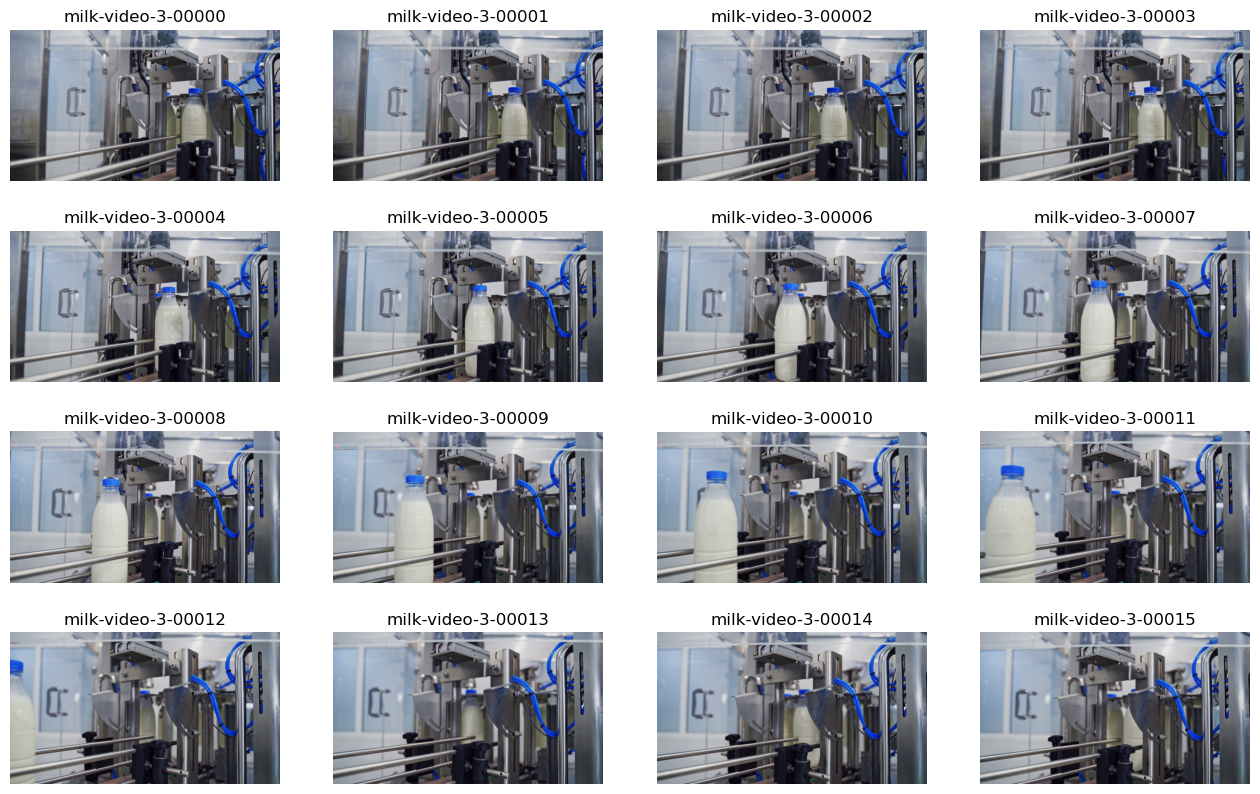

In [10]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

An ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [11]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "milk bottle": "bottle",
    "blue cap": "cap"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [12]:
DATASET_DIR_PATH = f"{HOME}\dataset"

invalid escape sequence '\d'
invalid escape sequence '\d'
invalid escape sequence '\d'


**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [13]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

Importing from timm.models.layers is deprecated, please import via timm.layers
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)


trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [14]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [15]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

124

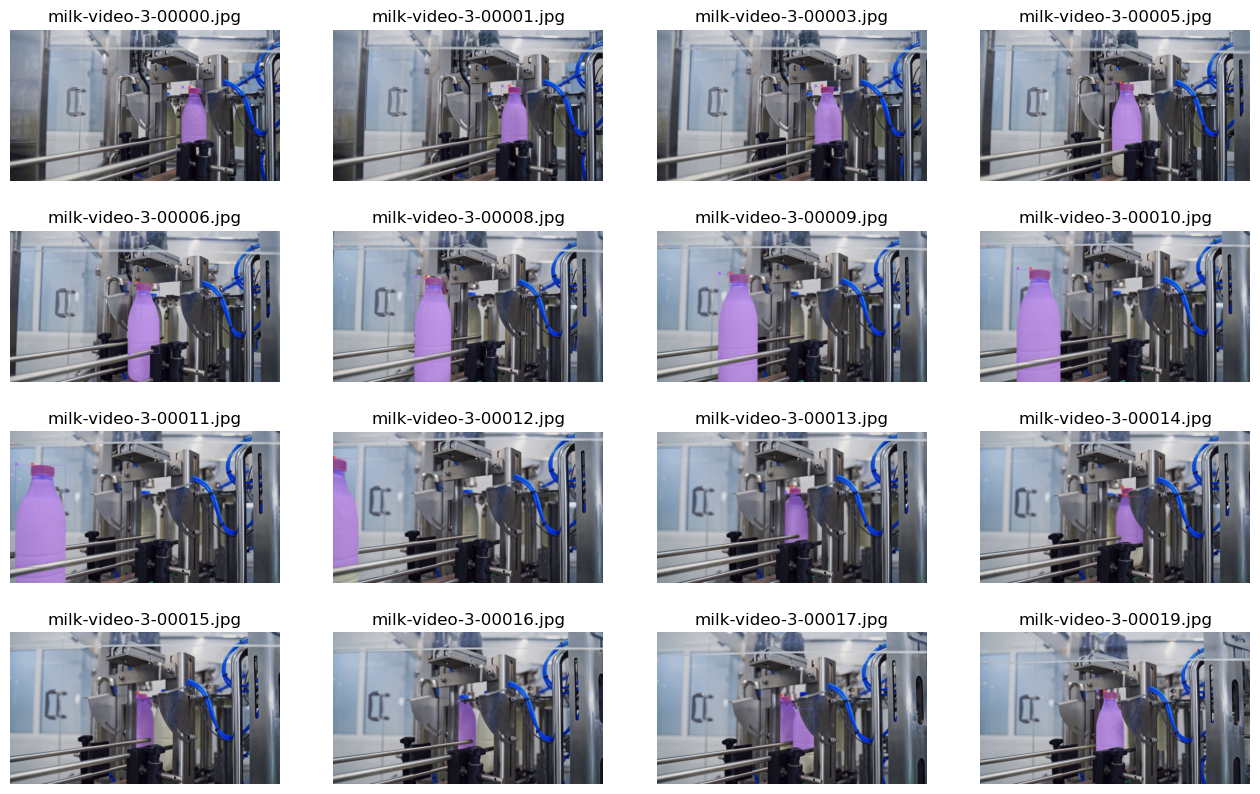

In [16]:
import supervision as sv
from pathlib import Path


mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

images = []
image_names = []
for i, (image_path, image, annotation) in enumerate(dataset):
    if i == SAMPLE_SIZE:
        break
    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = box_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=annotation)

    image_names.append(Path(image_path).name)
    images.append(annotated_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLO (You Only Look Once) and DETR (DEtection TRansformer).

In [17]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

d:\Repos\yolo-object-detection


100%|██████████| 6.23M/6.23M [00:00<00:00, 21.5MB/s]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
New https://pypi.org/project/ultralytics/8.3.28 available  Update with 'pip install -U ultr

In [18]:

import locale
locale.getpreferredencoding = lambda: "UTF-8"

## ⚖️ Evaluate target model

We can now take a look at artifacts from the run stored in the `runs` directory.

d:\Repos\yolo-object-detection


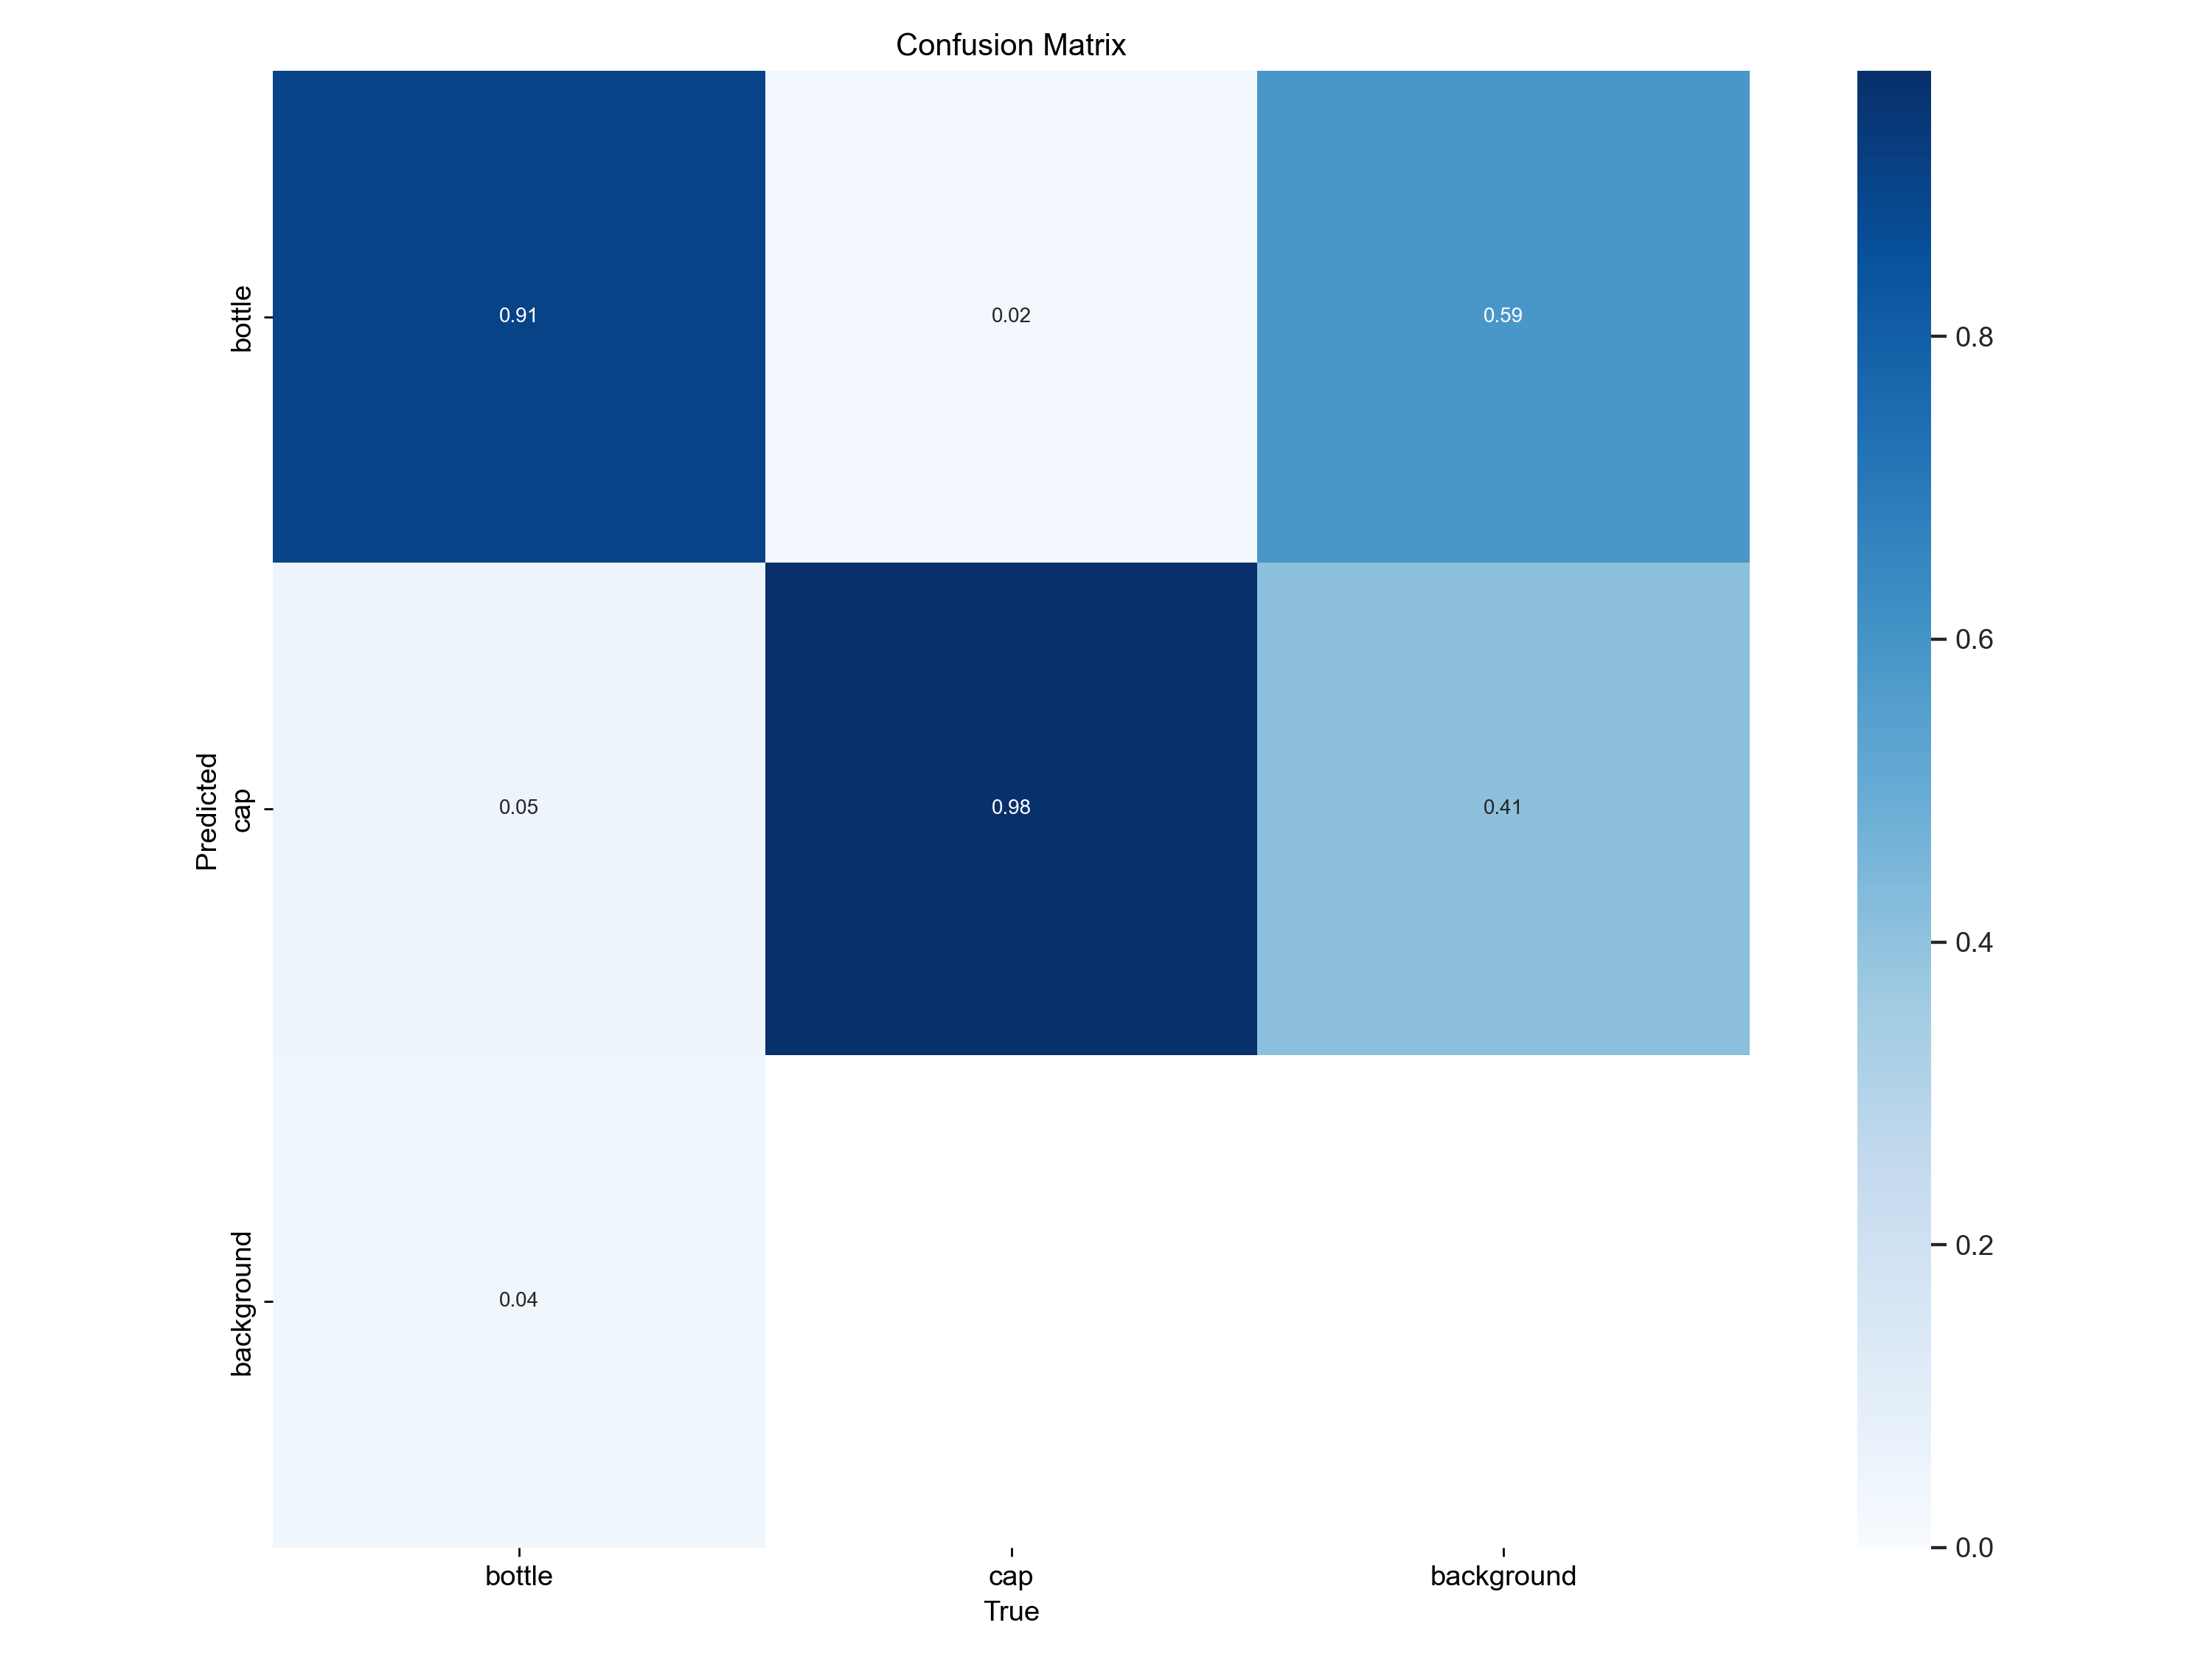

In [21]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

d:\Repos\yolo-object-detection


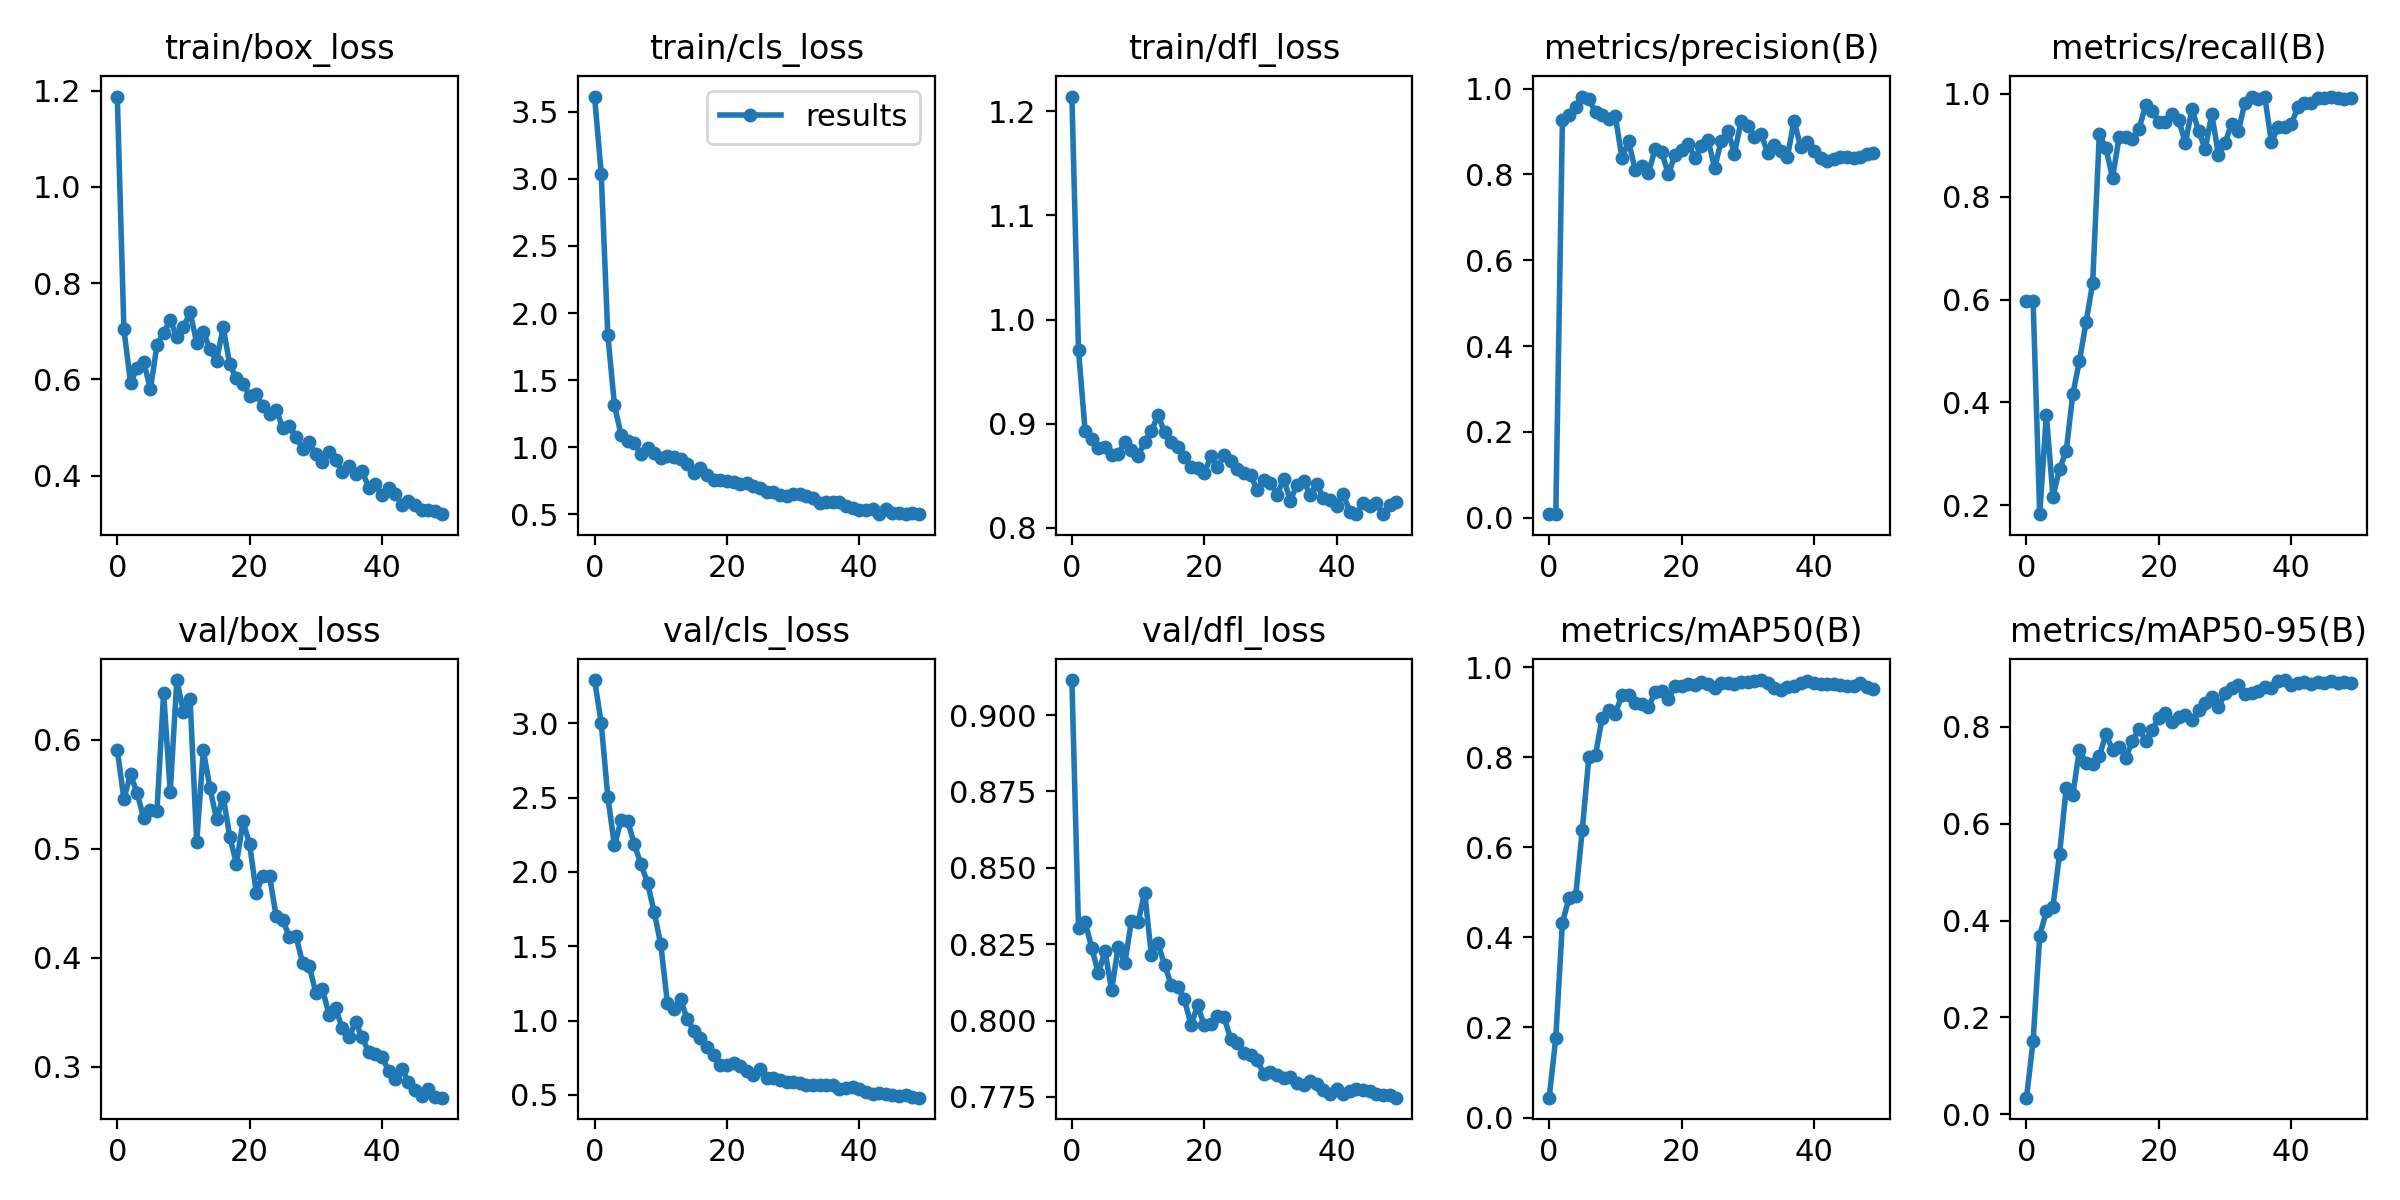

In [22]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

d:\Repos\yolo-object-detection


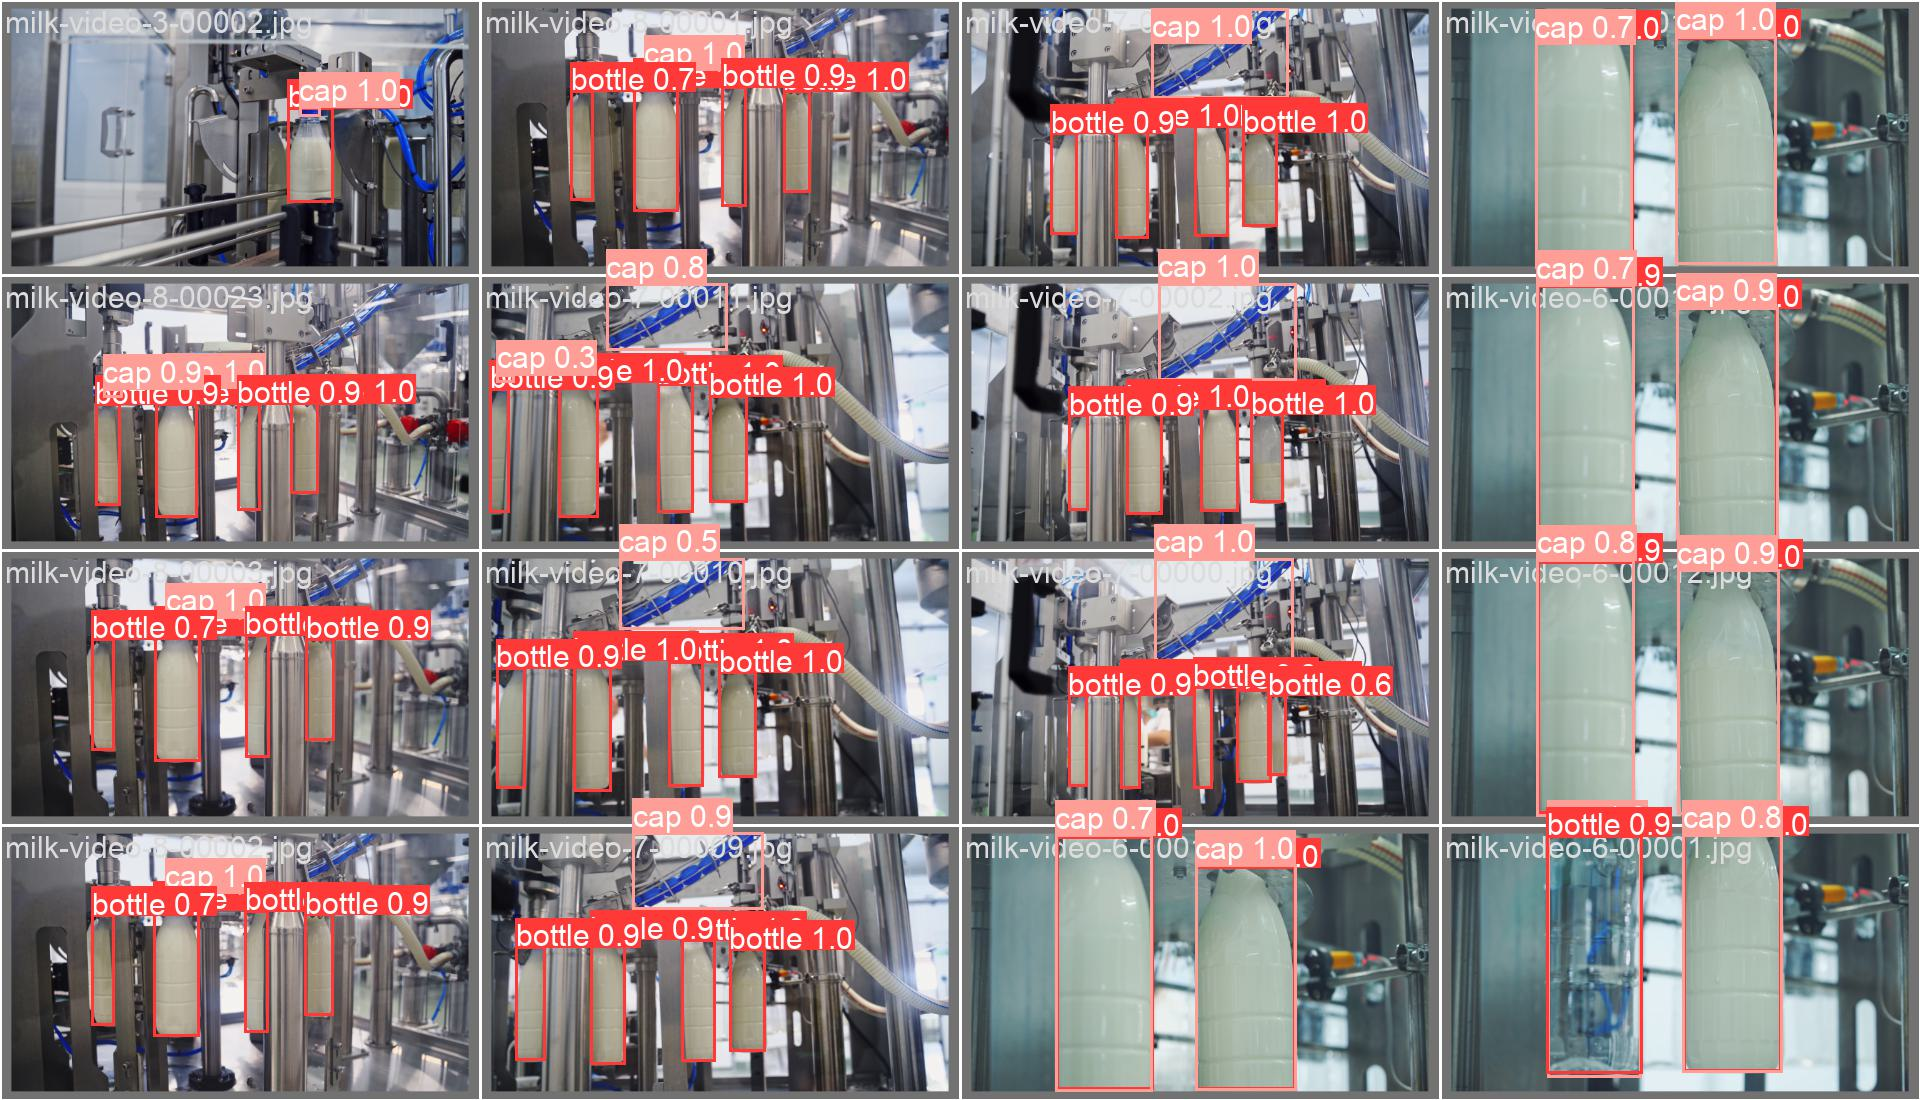

In [23]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [24]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [25]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

C:\ProgramData\anaconda3\Lib\site-packages\ultralytics\nn\tasks.py:357: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # lo

In [26]:
# Prediction saved as:
prediction_file = f"{HOME}/runs/detect/predict/milk-video-6.mp4"

  # 🏆 Congratulations

### ML for QA At Boeing
As we can see, object detection models are operating at very high accuracy.
Boeing would use this concept to train models to spot defects during assembly and before ever leaving for delivery.